# Preparación del entorno

In [1]:
!pip install wget

In [2]:
%%bash
pip install --upgrade duckdb
pip install --upgrade jupysql
pip install --upgrade duckdb-engine

In [3]:
import wget

url = "https://storage.googleapis.com/open-courses/dmeyf2023-8a1e/competencia_02_crudo.csv.gz"
ruta_destino = "/content/competencia_02_crudo.csv.gz"

wget.download(url, ruta_destino)

print("Archivo descargado en:", ruta_destino)

Archivo descargado en: /content/competencia_02_crudo.csv.gz


# Prueba con SQL

In [4]:
import duckdb
import pandas as pd

%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:////content/dmeyf.db

In [5]:
%%sql
create or replace table competencia_02 as
select
    *
from read_csv_auto('/content/competencia_02_crudo.csv.gz')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Success


# Construcción de Clase_ternaria

In [6]:
%sql select * from competencia_02 limit 5

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
0,29183981,201901,1,0,1,48,171,8304.31,42993.54,2501.04,...,0.0,8,0.00,-35773.32,2.33,5148,36602.13,54,0,5008.71
1,29184630,201901,1,0,1,57,296,18318.76,42597.26,14986.76,...,0.0,1,0.00,-67414.82,1149.57,3299,28503.06,10,0,1395.87
2,29185587,201901,1,0,1,77,296,20862.84,85481.31,4228.40,...,0.0,1,0.00,0.00,0.00,6790,5170.25,2,0,0.00
3,29185646,201901,1,0,1,58,231,25218.94,165317.78,4474.25,...,0.0,22,69653.59,-59422.00,0.00,7037,67991.90,31,0,2897.31
4,29187499,201901,1,0,1,69,349,5307.54,32374.08,4706.22,...,0.0,8,0.00,-4802.21,0.00,7596,4851.93,3,0,492.66


In [7]:
%%sql
select
    foto_mes
    , count(*) as cantidad -- cuenta cuantos casos hay en cada foto_mes
                           -- y lo guarda en un campo llamado cantidad
from competencia_02
group by foto_mes

,foto_mes,cantidad
0,201901,124864
1,201902,125898
2,201903,126536
3,201904,127059
4,201905,127683
5,201906,129181
6,201907,130551
7,201908,132615
8,201909,134267
9,201910,136515


In [8]:
%%sql
create or replace table targets as
with periodos as (
    select distinct foto_mes from competencia_02
), clientes as (
    select distinct numero_de_cliente from competencia_02
), todo as (
    select numero_de_cliente, foto_mes from clientes cross join periodos
), clase_ternaria as (
    select
        t.numero_de_cliente
        , t.foto_mes
        , if(c.numero_de_cliente is null, 0, 1) as mes_0
        , lead(mes_0, 1) over (partition by t.numero_de_cliente order by foto_mes) as mes_1
        , lead(mes_0, 2) over (partition by t.numero_de_cliente order by foto_mes) as mes_2
        , CASE
    WHEN (mes_0 = 1) AND (mes_1 = 1) AND (mes_2 = 1) THEN 'CONTINUA'
    WHEN (mes_0 = 1) AND (mes_1 = 0) AND (mes_2 = 1) THEN 'CONTINUA'
    WHEN (mes_0 = 1) AND (mes_1 = 0) AND (mes_2 = 0) THEN 'BAJA+1'
    WHEN (mes_0 = 1) AND (mes_1 = 1) AND (mes_2 = 0) THEN 'BAJA+2'
    ELSE NULL END AS clase_ternaria
    from todo t
    left join competencia_02 c using (numero_de_cliente, foto_mes)
) select
  foto_mes
  , numero_de_cliente
  , clase_ternaria
from clase_ternaria where mes_0 = 1

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Success


In [9]:
%%sql
alter table competencia_02 add column clase_ternaria VARCHAR(10)

,Success


In [10]:
%%sql
update competencia_02
set clase_ternaria = targets.clase_ternaria
from targets
where competencia_02.numero_de_cliente = targets.numero_de_cliente and competencia_02.foto_mes = targets.foto_mes;

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Success


In [11]:
%%sql
SELECT clase_ternaria, COUNT(*) AS count_clase
FROM targets
GROUP BY clase_ternaria;

,clase_ternaria,count_clase
0,None,329102
1,BAJA+2,18987
2,CONTINUA,4195938
3,BAJA+1,18783


In [12]:
%%sql
select
    foto_mes
    , count(*) as cantidad -- cuenta cuantos casos hay en cada foto_mes
                           -- y lo guarda en un campo llamado cantidad
from competencia_02
group by foto_mes

,foto_mes,cantidad
0,201901,124864
1,201902,125898
2,201903,126536
3,201904,127059
4,201905,127683
5,201906,129181
6,201907,130551
7,201908,132615
8,201909,134267
9,201910,136515


# Descarga índice de inflación

## Armado del índice

In [13]:
!pip install pandas requests

In [14]:
import requests
from io import BytesIO

In [15]:
# URL del archivo
url = "https://www.indec.gob.ar/ftp/cuadros/economia/sh_ipc_08_23.xls"

# Descargar el archivo y cargar los datos de la hoja correcta
response = requests.get(url)
xls = pd.ExcelFile(BytesIO(response.content))

# Cargar los datos desde la hoja de interés
inflacion = pd.read_excel(xls, sheet_name="Índices IPC Cobertura Nacional", skiprows=5, usecols="B:CC")

In [16]:
inflacion

,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,...,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01,2023-07-01
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100,101.5859,103.6859,106.1476,108.9667,110.5301,111.8477,113.7852,115.3819,117.5719,...,1028.706,1079.2787,1134.5875,1202.979,1282.7091,1381.1601,1497.2147,1613.5895,1709.6115,1818.0838
4,100,101.3024,103.1605,106.0143,108.3515,109.7631,110.7483,112.0115,114.3467,116.4048,...,1096.5069,1135.001,1187.9252,1268.3385,1392.3999,1522.5337,1677.0441,1774.4119,1848.0332,1954.5101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Transponer los datos y establecer la tercera fila como encabezado
inflacion = inflacion.transpose()


In [18]:
inflacion = inflacion[3]

In [19]:
inflacion

2016-12-01          100
2017-01-01     101.5859
2017-02-01     103.6859
2017-03-01     106.1476
2017-04-01     108.9667
                ...    
2023-03-01    1381.1601
2023-04-01    1497.2147
2023-05-01    1613.5895
2023-06-01    1709.6115
2023-07-01    1818.0838
Name: 3, Length: 80, dtype: object

In [20]:
# Pasar a data frame
import pandas as pd

inflacion = pd.DataFrame(inflacion)

In [21]:
inflacion.index.name='foto_mes'

In [22]:
inflacion

,3
foto_mes,
2016-12-01,100
2017-01-01,101.5859
2017-02-01,103.6859
2017-03-01,106.1476
2017-04-01,108.9667
...,...
2023-03-01,1381.1601
2023-04-01,1497.2147
2023-05-01,1613.5895


In [23]:
# Renombrar la columna
inflacion.columns = ["indice_inflacion"]

# Eliminar las filas con valores nulos
inflacion.dropna(inplace=True)

# Eliminar guiones y los últimos dos dígitos de la columna "foto_mes"
inflacion.index = inflacion.index.astype(str).str.replace('-', '').str[:-2]

# Mostrar las primeras filas del DataFrame resultante
inflacion.head()

,indice_inflacion
foto_mes,
201612,100
201701,101.5859
201702,103.6859
201703,106.1476
201704,108.9667


## Inflación A Sql

In [24]:
# Guardar el DataFrame como un archivo CSV
inflacion.to_csv('/content/inflacion.csv')

In [25]:
%%sql
create or replace table inflacion as
select
    *
from read_csv_auto('/content/inflacion.csv')

,Success


In [26]:
%%sql
select *
from inflacion

,foto_mes,indice_inflacion
0,201612,100.0000
1,201701,101.5859
2,201702,103.6859
3,201703,106.1476
4,201704,108.9667
...,...,...
75,202303,1381.1601
76,202304,1497.2147
77,202305,1613.5895
78,202306,1709.6115


Agrego inflación acumulada hasta 202107 para hacer el drifting

In [27]:
%%sql
ALTER TABLE inflacion
ADD COLUMN indice_inflacion_acumulada FLOAT; -- Adjust the data type as needed

WITH InflacionAcumulada AS (
    SELECT
        foto_mes,
        indice_inflacion,
        (
            (SELECT indice_inflacion FROM inflacion WHERE foto_mes = '202107') / indice_inflacion
        ) AS inflacion_acumulada
    FROM
        inflacion
)
UPDATE inflacion
SET indice_inflacion_acumulada = (SELECT inflacion_acumulada FROM InflacionAcumulada WHERE inflacion.foto_mes = InflacionAcumulada.foto_mes);


,Count
0,80


In [28]:
%%sql
select *
from inflacion

,foto_mes,indice_inflacion,indice_inflacion_acumulada
0,201612,100.0000,4.980987
1,201701,101.5859,4.903227
2,201702,103.6859,4.803919
3,201703,106.1476,4.692510
4,201704,108.9667,4.571109
...,...,...,...
75,202303,1381.1601,0.360638
76,202304,1497.2147,0.332684
77,202305,1613.5895,0.308690
78,202306,1709.6115,0.291352


# Inner join competencia_02 e inflación

In [ ]:
%%sql
SELECT
    *
FROM
    competencia_02 c2
INNER JOIN
    inflacion i
ON
    c2.foto_mes = i.foto_mes;

In [ ]:
%%sql
SELECT
    *
FROM
    competencia_02 c2

# Feauture Engineering

## **ctrx_quarter**	--	Cantidad de movimientos voluntarios en las cuentas bancarias (no tarjeta de credito) que el cliente realizó en los ultimos 90 dias.

En 2020 hay un cambio fuerte, pero es efecto pandemia

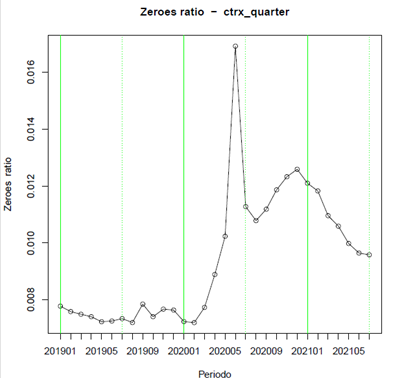

Al ser una variable tan importante, le hago una transformación con la media móvil de 6 períodos para ver la tendencia

In [ ]:
%%sql
select
  numero_de_cliente
  , foto_mes
  , ctrx_quarter
  , avg(ctrx_quarter) over (partition by numero_de_cliente
                            order by foto_mes
                            rows between 6 preceding and current row) as avg_6_ctrx_quarter
from competencia_02
limit 10

##	mcaja_ahorro	--	Monto total de la caja de ahorro del Paquete Premium

Acá se puede hacer: mcaja_ahorro + mcuenta_corriente + mplazo_fijo + minversiones1 + minversiones2  + mcaja_ahorro_adicional + mcaja_ahorro_dolares + mcuenta_corriente_adicional + mcuentas_saldo + mcuenta_debitos_automaticos

In [ ]:
%%sql
SELECT
    foto_mes,
    mcaja_ahorro + mcuenta_corriente + mplazo_fijo + minversiones1 + minversiones2 +
    mcaja_ahorro_adicional + mcaja_ahorro_dolares + mcuenta_corriente_adicional +
    mcuentas_saldo + mcuenta_debitos_automaticos AS total_mcaja
INTO competencia_02_con_total
FROM competencia_02;

### Eliminar las variables individuales de la tabla original:
%%sql
ALTER TABLE competencia_02
DROP COLUMN mcaja_ahorro,
DROP COLUMN mcuenta_corriente,
DROP COLUMN mplazo_fijo,
DROP COLUMN minversiones1,
DROP COLUMN minversiones2,
DROP COLUMN mcaja_ahorro_adicional,
DROP COLUMN mcaja_ahorro_dolares,
DROP COLUMN mcuenta_corriente_adicional,
DROP COLUMN mcuentas_saldo,
DROP COLUMN mcuenta_debitos_automaticos;

Drifting: llevo todo a precios del último mes (202107)

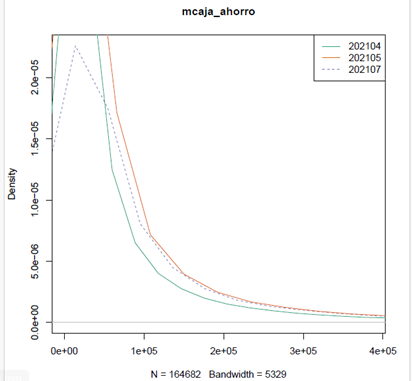

Una posibilidad: es por cada fila dejarle la inflación acumulada entre ese mes y el máximo (202107)

In [ ]:
%%sql
SELECT
    foto_mes,
    total_mcaja * inflacion_acumulada AS total_mcaja_multiplicado
FROM
    competencia_02;

# (Teoría Feauture Engineering)

Vamos por unos ejemplos simples. Que pasa si quiero agregar un feature que muestre el valor del periodo anterior?

In [ ]:
%%sql
select
  numero_de_cliente
  , foto_mes
  , ctrx_quarter
  , lag(ctrx_quarter, 1) over (partition by numero_de_cliente order by foto_mes) as lag_1_ctrx_quarter
from competencia_02
limit 10

,numero_de_cliente,foto_mes,ctrx_quarter,lag_1_ctrx_quarter
0,29188883,201901,43,NaN
1,29188883,201902,45,43.0
2,29188883,201903,39,45.0
3,29188883,201904,38,39.0
4,29188883,201905,39,38.0
5,29188883,201906,41,39.0
6,29188883,201907,34,41.0
7,29188883,201908,30,34.0
8,29188883,201909,25,30.0
9,29188883,201910,30,25.0


Podemos calcular el delta (diferencia) entre el valor pasado y el presente, para uno o varios meses

In [ ]:
%%sql
select
  numero_de_cliente
  , foto_mes
  , ctrx_quarter
  , lag(ctrx_quarter, 1) over (partition by numero_de_cliente order by foto_mes) as lag_1_ctrx_quarter
  , ctrx_quarter - lag_1_ctrx_quarter as delta_1_ctrx_quarter
  , ctrx_quarter - lag(ctrx_quarter, 2) over (partition by numero_de_cliente order by foto_mes) as lag_2_ctrx_quarter
from competencia_02
limit 10


,numero_de_cliente,foto_mes,ctrx_quarter,lag_1_ctrx_quarter,delta_1_ctrx_quarter,lag_2_ctrx_quarter
0,29188883,201901,43,NaN,NaN,NaN
1,29188883,201902,45,43.0,2.0,NaN
2,29188883,201903,39,45.0,-6.0,-4.0
3,29188883,201904,38,39.0,-1.0,-7.0
4,29188883,201905,39,38.0,1.0,0.0
5,29188883,201906,41,39.0,2.0,3.0
6,29188883,201907,34,41.0,-7.0,-5.0
7,29188883,201908,30,34.0,-4.0,-11.0
8,29188883,201909,25,30.0,-5.0,-9.0
9,29188883,201910,30,25.0,5.0,0.0


Si necesitamos ya no solo traer un valor del pasado, sino una secuencia de valores, por ejemplo para calcular la media móvil en los últimos 6 meses, se puede hacer fácilmente

In [ ]:
%%sql
select
  numero_de_cliente
  , foto_mes
  , ctrx_quarter
  , avg(ctrx_quarter) over (partition by numero_de_cliente
                            order by foto_mes
                            rows between 6 preceding and current row) as avg_6_ctrx_quarter
from competencia_02
limit 10

,numero_de_cliente,foto_mes,ctrx_quarter,avg_6_ctrx_quarter
0,29188883,201901,43,43.000000
1,29188883,201902,45,44.000000
2,29188883,201903,39,42.333333
3,29188883,201904,38,41.250000
4,29188883,201905,39,40.800000
5,29188883,201906,41,40.833333
6,29188883,201907,34,39.857143
7,29188883,201908,30,38.000000
8,29188883,201909,25,35.142857
9,29188883,201910,30,33.857143


- Para el cliente 29188883 para la foto 201910, se puede chequear que la nueva feature se construye con la siguiente cuenta (30 + 25 + 30 + 34 + 41 + 39 + 38) / 7
- Si embargo puede resultar incómodo escribir constantemente el over partition sobre todo si se buscan aplicar muchas veces para distintas funciones. Para reducir el código se puede usar la siguiente sintaxis

In [ ]:
%%sql
select
  numero_de_cliente
  , foto_mes
  , ctrx_quarter
  , avg(ctrx_quarter) over ventana_6 as ctrx_quarter_media_6
  , max(ctrx_quarter) over ventana_6 as ctrx_quarter_max_6
  , min(ctrx_quarter) over ventana_6 as ctrx_quarter_min_6
from competencia_02
window ventana_6 as (partition by numero_de_cliente order by foto_mes rows between 6 preceding and current row)
limit 10

,numero_de_cliente,foto_mes,ctrx_quarter,ctrx_quarter_media_6,ctrx_quarter_max_6,ctrx_quarter_min_6
0,29188883,201901,43,43.000000,43,43
1,29188883,201902,45,44.000000,45,43
2,29188883,201903,39,42.333333,45,39
3,29188883,201904,38,41.250000,45,38
4,29188883,201905,39,40.800000,45,38
5,29188883,201906,41,40.833333,45,38
6,29188883,201907,34,39.857143,45,34
7,29188883,201908,30,38.000000,45,30
8,29188883,201909,25,35.142857,41,25
9,29188883,201910,30,33.857143,41,25


Para saber más que funciones tenemos disponibles, recomiendo ver los siguientes links:
- https://duckdb.org/docs/archive/0.8.1/sql/window_functions
- https://duckdb.org/docs/archive/0.8.1/sql/aggregates

Un caso más, que ni me voy a molestar en explicar que significa...

In [ ]:
%%sql
select
  numero_de_cliente
  , foto_mes
  , ctrx_quarter
  ,regr_slope(ctrx_quarter, cliente_antiguedad) over ventana_6 as ctrx_quarter_slope_6
from competencia_02
window ventana_6 as (partition by numero_de_cliente order by foto_mes rows between 6 preceding and current row)
limit 10


,numero_de_cliente,foto_mes,ctrx_quarter,ctrx_quarter_slope_6
0,29188883,201901,43,NaN
1,29188883,201902,45,2.000000
2,29188883,201903,39,-2.000000
3,29188883,201904,38,-2.100000
4,29188883,201905,39,-1.500000
5,29188883,201906,41,-0.828571
6,29188883,201907,34,-1.250000
7,29188883,201908,30,-1.857143
8,29188883,201909,25,-2.250000
9,29188883,201910,30,-2.250000


... Alguno dirá "tenemos que escribir todo esto a mano? Son muchas variables!". Bueno no, use los conocimientos de programación para que la computadora trabaje para usted. Si tenemos una lista de campos

In [ ]:

campos = ['active_quarter', 'cliente_vip', 'internet', 'cliente_edad', 'cliente_antiguedad', 'mrentabilidad', 'mrentabilidad_annual', 'mcomisiones', 'mactivos_margen', 'mpasivos_margen', 'cproductos', 'tcuentas', 'ccuenta_corriente', 'mcuenta_corriente_adicional', 'mcuenta_corriente', 'ccaja_ahorro', 'mcaja_ahorro', 'mcaja_ahorro_adicional', 'mcaja_ahorro_dolares', 'cdescubierto_preacordado', 'mcuentas_saldo', 'ctarjeta_debito', 'ctarjeta_debito_transacciones', 'mautoservicio', 'ctarjeta_visa', 'ctarjeta_visa_transacciones', 'mtarjeta_visa_consumo', 'ctarjeta_master', 'ctarjeta_master_transacciones', 'mtarjeta_master_consumo', 'cprestamos_personales', 'mprestamos_personales', 'cprestamos_prendarios', 'mprestamos_prendarios', 'cprestamos_hipotecarios', 'mprestamos_hipotecarios', 'cplazo_fijo', 'mplazo_fijo_dolares', 'mplazo_fijo_pesos', 'cinversion1', 'minversion1_pesos', 'minversion1_dolares', 'cinversion2', 'minversion2', 'cseguro_vida', 'cseguro_auto', 'cseguro_vivienda', 'cseguro_accidentes_personales', 'ccaja_seguridad', 'cpayroll_trx', 'mpayroll', 'mpayroll2', 'cpayroll2_trx', 'ccuenta_debitos_automaticos', 'mcuenta_debitos_automaticos', 'ctarjeta_visa_debitos_automaticos', 'mttarjeta_visa_debitos_automaticos', 'ctarjeta_master_debitos_automaticos', 'mttarjeta_master_debitos_automaticos', 'cpagodeservicios', 'mpagodeservicios', 'cpagomiscuentas', 'mpagomiscuentas', 'ccajeros_propios_descuentos', 'mcajeros_propios_descuentos', 'ctarjeta_visa_descuentos', 'mtarjeta_visa_descuentos', 'ctarjeta_master_descuentos', 'mtarjeta_master_descuentos', 'ccomisiones_mantenimiento', 'mcomisiones_mantenimiento', 'ccomisiones_otras', 'mcomisiones_otras', 'cforex', 'cforex_buy', 'mforex_buy', 'cforex_sell', 'mforex_sell', 'ctransferencias_recibidas', 'mtransferencias_recibidas', 'ctransferencias_emitidas', 'mtransferencias_emitidas', 'cextraccion_autoservicio', 'mextraccion_autoservicio', 'ccheques_depositados', 'mcheques_depositados', 'ccheques_emitidos', 'mcheques_emitidos', 'ccheques_depositados_rechazados', 'mcheques_depositados_rechazados', 'ccheques_emitidos_rechazados', 'mcheques_emitidos_rechazados', 'tcallcenter', 'ccallcenter_transacciones', 'thomebanking', 'chomebanking_transacciones', 'ccajas_transacciones', 'ccajas_consultas', 'ccajas_depositos', 'ccajas_extracciones', 'ccajas_otras', 'catm_trx', 'matm', 'catm_trx_other', 'matm_other', 'ctrx_quarter', 'Master_delinquency', 'Master_status', 'Master_mfinanciacion_limite', 'Master_Fvencimiento', 'Master_Finiciomora', 'Master_msaldototal', 'Master_msaldopesos', 'Master_msaldodolares', 'Master_mconsumospesos', 'Master_mconsumosdolares', 'Master_mlimitecompra', 'Master_madelantopesos', 'Master_madelantodolares', 'Master_fultimo_cierre', 'Master_mpagado', 'Master_mpagospesos', 'Master_mpagosdolares', 'Master_fechaalta', 'Master_mconsumototal', 'Master_cconsumos', 'Master_cadelantosefectivo', 'Master_mpagominimo', 'Visa_delinquency', 'Visa_status', 'Visa_mfinanciacion_limite', 'Visa_Fvencimiento', 'Visa_Finiciomora', 'Visa_msaldototal', 'Visa_msaldopesos', 'Visa_msaldodolares', 'Visa_mconsumospesos', 'Visa_mconsumosdolares', 'Visa_mlimitecompra', 'Visa_madelantopesos', 'Visa_madelantodolares', 'Visa_fultimo_cierre', 'Visa_mpagado', 'Visa_mpagospesos', 'Visa_mpagosdolares', 'Visa_fechaalta', 'Visa_mconsumototal', 'Visa_cconsumos', 'Visa_cadelantosefectivo', 'Visa_mpagominimo']


#Podemos hacer un script muy sencillo que nos genere el texto que hay que poner en una query para generar esas variables
nuevos_features = ""
for campo in campos:
  nuevos_features += f"\n, regr_slope({campo}, cliente_antiguedad) over ventana_6 as ctrx_{campo}_slope_6"
print(nuevos_features)


, regr_slope(active_quarter, cliente_antiguedad) over ventana_6 as ctrx_active_quarter_slope_6
, regr_slope(cliente_vip, cliente_antiguedad) over ventana_6 as ctrx_cliente_vip_slope_6
, regr_slope(internet, cliente_antiguedad) over ventana_6 as ctrx_internet_slope_6
, regr_slope(cliente_edad, cliente_antiguedad) over ventana_6 as ctrx_cliente_edad_slope_6
, regr_slope(cliente_antiguedad, cliente_antiguedad) over ventana_6 as ctrx_cliente_antiguedad_slope_6
, regr_slope(mrentabilidad, cliente_antiguedad) over ventana_6 as ctrx_mrentabilidad_slope_6
, regr_slope(mrentabilidad_annual, cliente_antiguedad) over ventana_6 as ctrx_mrentabilidad_annual_slope_6
, regr_slope(mcomisiones, cliente_antiguedad) over ventana_6 as ctrx_mcomisiones_slope_6
, regr_slope(mactivos_margen, cliente_antiguedad) over ventana_6 as ctrx_mactivos_margen_slope_6
, regr_slope(mpasivos_margen, cliente_antiguedad) over ventana_6 as ctrx_mpasivos_margen_slope_6
, regr_slope(cproductos, cliente_antiguedad) over venta

In [ ]:
%%sql
copy competencia_02 to '/content/competencia_02.csv.gz' (FORMAT CSV, HEADER)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Success
